### About

A sample solution of the images recognition challenge using tensorflow.

In [1]:
import os
import cv2
import random
import imutils
import argparse
import numpy as np
from imutils import contours

In [2]:
## import custom functions 
from symbols_extractor import load_data
from symbols_extractor import fetch_symbols_from_captcha                                

### Dependencies

You may need to download [pycaptcha](https://github.com/vdmitriyev/pycaptcha) utility to generate training dataset. Note that default repository for this utility configured as - **c:\repositories\pycaptcha\** (but you may change it).

### Import Dataset

Don't forget to change the path to generated by the "pycaptcha" images.

In [4]:
train_dir = 'c:\\repositories\\pycaptcha\\train\\'
images, labels = load_data(train_dir)

In [5]:
symbols = fetch_symbols_from_captcha('images\images-with-digits.png')

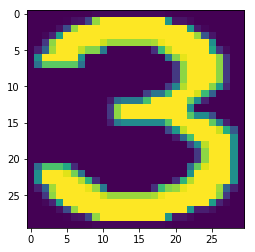

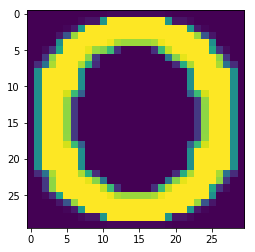

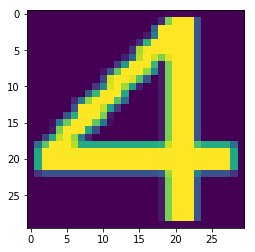

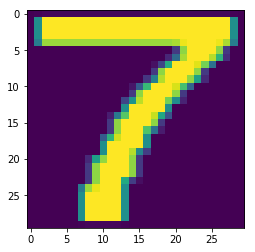

In [7]:
# simple check of images
import matplotlib.pyplot as plt
for image in symbols:
    plt.imshow(image)    
    plt.show()

### Train TensorFlow Model

In [11]:
import tensorflow as tf

def train_model_tf_version2(images, labels):
    ''' A simple model made with tensorflow'''

    LABEL_SIZE = 10
    IMAGE_SIZE = 30 * 30
    print('label_size: %s, image_size: %s' % (LABEL_SIZE, IMAGE_SIZE))

    # variable in the graph for input data
    x = tf.placeholder(tf.float32, [None, IMAGE_SIZE])
    y_ = tf.placeholder(tf.float32, [None, LABEL_SIZE])

    # define the model
    W = tf.Variable(tf.zeros([IMAGE_SIZE, LABEL_SIZE]))
    b = tf.Variable(tf.zeros([LABEL_SIZE]))
    y = tf.matmul(x, W) + b

    # Define loss and optimizer
    diff = tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y)
    cross_entropy = tf.reduce_mean(diff)
    train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)

    # forward prop
    predict = tf.argmax(y, axis=1)
    expect = tf.argmax(y_, axis=1)

    # evaluate accuracy
    correct_prediction = tf.equal(predict, expect)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    images_resized = []
    for image in images:
        #image = tf.image.per_image_standardization(image)
        image = image / 255.0
        image = image.reshape(30 * 30)
        images_resized.append(image)
    images_resized = np.array(images_resized)
    print(images_resized.shape)

    labels_resized = []
    for index, label in enumerate(labels):
        labels_resized.append([0 for x in range(10)])
        labels_resized[index][label] = 1
    labels_resized = np.array(labels_resized)
    print(labels_resized.shape)
    print(labels_resized[0])

    tf_sess = tf.Session()
    tf_sess.run(tf.global_variables_initializer())   
    
    MAX_STEPS = 201
    
    # Train
    print ('Start with training ...')
    for i in range(MAX_STEPS):
        tf_sess.run(train_step, feed_dict={x: images_resized, y_: labels_resized})
        if i % 10 == 0:
            r = tf_sess.run(accuracy, feed_dict={x: images_resized, y_: labels_resized})
            print('step = %s, accuracy = %.2f%%' % (i, r * 100))
            
    print ('Done with training ...')
    
    return tf_sess, x, y

tf_sess, x, y = train_model_tf_version2(images, labels)

label_size: 10, image_size: 900
(5000, 900)
(5000, 10)
[1 0 0 0 0 0 0 0 0 0]
Start with training ...
step = 0, accuracy = 100.00%
step = 10, accuracy = 100.00%
step = 20, accuracy = 100.00%
step = 30, accuracy = 100.00%
step = 40, accuracy = 100.00%
step = 50, accuracy = 100.00%
step = 60, accuracy = 100.00%
step = 70, accuracy = 100.00%
step = 80, accuracy = 100.00%
step = 90, accuracy = 100.00%
step = 100, accuracy = 100.00%
step = 110, accuracy = 100.00%
step = 120, accuracy = 100.00%
step = 130, accuracy = 100.00%
step = 140, accuracy = 100.00%
step = 150, accuracy = 100.00%
step = 160, accuracy = 100.00%
step = 170, accuracy = 100.00%
step = 180, accuracy = 100.00%
step = 190, accuracy = 100.00%
step = 200, accuracy = 100.00%
Done with training ...


### Validate Model Using One Image

Predicted value: [3]
Real value (see image below):


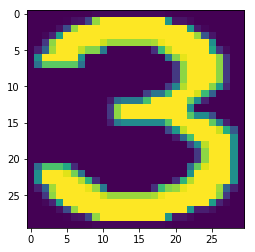

----
Predicted value: [0]
Real value (see image below):


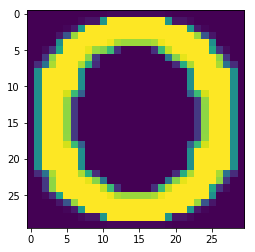

----
Predicted value: [4]
Real value (see image below):


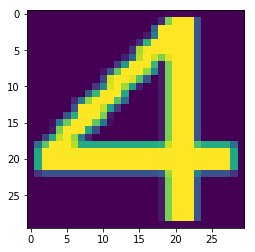

----
Predicted value: [7]
Real value (see image below):


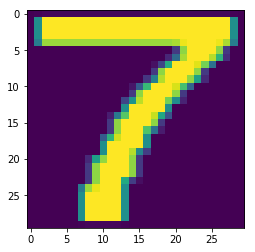

----


In [9]:
symbols = fetch_symbols_from_captcha('images/images-with-digits.png')

input_resized = []
for image in symbols:
    image = image / 255.0
    image = image.reshape(30 * 30)
    input_resized.append(image)    
    
input_resized = np.array(input_resized)
#print(input_resized.shape)

for index, image in enumerate (input_resized):
    predicted = tf_sess.run(tf.argmax(y, axis=1), feed_dict={x: [image]})
    print('Predicted value: {0}'.format(predicted))
    # simple image check
    print('Real value (see image below):')
    plt.imshow(symbols[index])
    plt.show()
    print('----')

### Validate Model Using A Set Of Images

Don't forget to change the path to generated by the "pycaptcha" images.

In [10]:
data_directory = 'c:\\repositories\\pycaptcha\\.captchas\\'

directories = [d for d in os.listdir(data_directory)
               if os.path.isdir(os.path.join(data_directory, d))]

accuracy = 0

for d in directories:
    sub_directory = os.path.join(data_directory, d)
    
    label_path = os.path.join(sub_directory, d) + '.ans'
    label = 0    
    with open(label_path, 'r') as _file:
        label = _file.read().strip()
        
    image_path = os.path.join(sub_directory, d) + '.png'
    symbols = fetch_symbols_from_captcha(image_path)
    
    input_resized = []
    for image in symbols:
        image = image / 255.0
        image = image.reshape(30 * 30)
        input_resized.append(image)
        
    input_resized = np.array(input_resized)
    
    correct, wrong = 0, 0
    for index, image in enumerate(input_resized):
        predicted = tf_sess.run(tf.argmax(y, axis=1), feed_dict={x: [image]})
        diff = int(predicted[0]) - int(label[index])
        if diff == 0:
            correct+=1
        else:
            wrong+=1
            print (predicted[0], label[index], d)
            
    accuracy += correct / len(symbols)
    
print('accuracy: {}'.format(accuracy/len(directories)))

accuracy: 1.0
